# Setup

In [ ]:
%%capture
!pip show transformers
!pip show accelerate
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install transformers
!pip install pytorch-lightning
!pip install --upgrade transformers
!pip install datasets

# Preprocessing

In [7]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

# Train Data (Roberta + Llama Union), 11449 rows
toxicity_train_df = pd.read_csv('toxic_union.csv',  on_bad_lines='skip')
toxicity_train_df = toxicity_train_df.dropna()

# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()

# Train Data - 52662 rows after pre-processing (done above)
# toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

# toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# # Check if any category is above the 0.33 threshold
# toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)

# # Convert boolean values to 1.0 for True and 0.0 for False
# toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

# toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

# print("\nClass distribution in training data before undersampling:")
# print(toxicity_train_df['toxic'].value_counts())

# print("\nClass distribution in test data before undersampling:")
# print(toxicity_test_df['toxic'].value_counts())



# # Fraction of the majority class you want to keep (e.g., 0.2 for 20%)
# undersample_fraction = 0.5

# # Separate the majority and minority classes in training data
# majority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 0]
# minority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 1]

# # Undersample the majority class in training data
# undersampled_majority_class_train = majority_class_train.sample(frac=undersample_fraction, random_state=42)

# # Concatenate the undersampled majority class with the minority class in training data
# undersampled_train_df = pd.concat([undersampled_majority_class_train, minority_class_train])

# # Shuffle the undersampled training dataframe
# toxicity_train_df = undersampled_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Separate the majority and minority classes in test data
# majority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 0]
# minority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 1]

# # Display the class distribution after undersampling
# print("\nClass distribution in training data after undersampling:")
# print(toxicity_train_df['toxic'].value_counts())

# print("\nClass distribution in test data after undersampling:")
# print(toxicity_test_df['toxic'].value_counts())

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

<ipython-input-7-febd0e60f7bd>:24: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)


Toxic train examples
                                        comment_text  toxic  llama  union
0  Confused why people are spamming things like J...      0      0      0
1       Nice thats my first time in Hasan Lifestream      0      1      1
2     THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO      0      0      0
3  Dont forget to check ur cocks before stream st...      0      0      0
Toxic test examples
                                          comment_text  toxic  obscene  \
24                                                BS !    0.0      0.0   
56   Hodad...does your user handle refer to your da...    0.0      0.0   
156  Many of them were wearing red Na'i Aupuni shir...    0.0      0.0   
181  "Methinks your comment is indicative of your n...    0.0      0.0   

     sexual_explicit    threat  insult  identity_attack  
24               0.0  0.000000     0.0              0.0  
56               0.0  0.000000     0.0              0.0  
156              0.0  0.000000     0.0      

<ipython-input-7-febd0e60f7bd>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
<ipython-input-7-febd0e60f7bd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
<ipython-input-7-febd0e60f7bd>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Test Lengths of DFs

In [8]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

11449
7287


# Visualization of toxicity in train

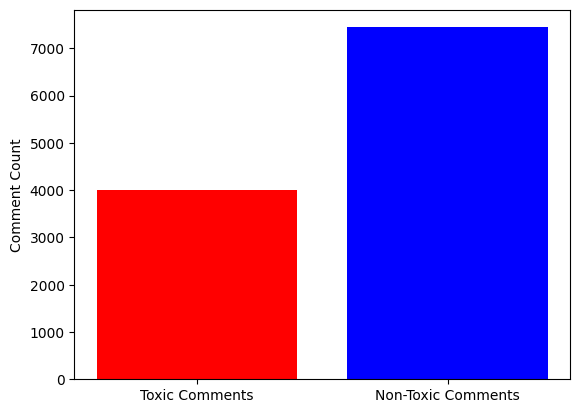

In [9]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['union'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

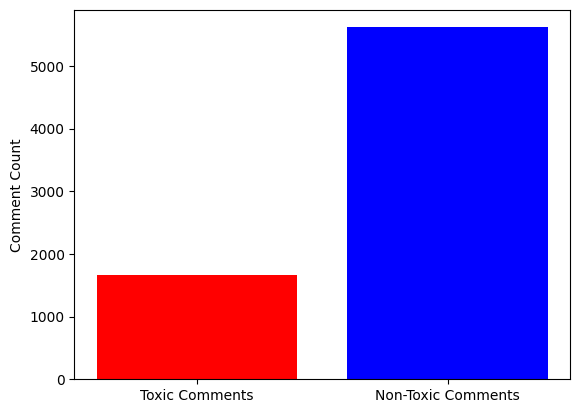

In [10]:
# Count toxic and non-toxic comments
toxic_count = toxicity_test_df['toxic'].sum()
non_toxic_count = len(toxicity_test_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Splitting and Labelling

In [12]:
model_name = "roberta-base"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'union']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['union'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
["Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej", 'Nice thats my first time in Hasan Lifestream', 'THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO', 'Dont forget to check ur cocks before stream starts', 'THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO']
train_labels:
[0, 1, 0, 0, 0]
test_texts
['BS !', 'Hodad...does your user handle refer to your daughter??', "Many of them were wearing red Na'i Aupuni shirts.  Does that not show support for federal recognition?", '"Methinks your comment is indicative of your need to understand the Christian faith which does not require the subservience of woman as much as care and love for them by the man - ""as Christ loved the church""."', "And sometimes it's just salting the earth..."]
test_labels:
[0.0, 0.0, 0.0, 0.0, 0.0]


# Dataset

In [13]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Train Dataset
Sample 1:
Encoding keys: ['<s>', 'brother', 'Ġhow', 'Ġare', 'Ġyou', 'Ġonly', 'Ġever', 'Ġyelling', 'Ġat', 'Ġchat', 'ters', 'Ġwhen', 'Ġi', 'Ġpop', 'Ġin', 'Ġhere', 'Ġ:(', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

# Native PyTorch (instead of HF Trainer)

In [19]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=1e-6)

num_train_epochs = 1
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 20 == 0:  # Print progress every 2 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")
#   for batch in train_loader:
#     optim.zero_grad()
#     input_ids = batch['input_ids'].to(device)
#     attention_mask = batch['attention_mask'].to(device)
#     labels = batch['labels'].to(device)

#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

#     loss = outputs[0]
#     loss.backward()
#     optim.step()

model.eval()

model.save_pretrained('/usr/fine_tuned_roberta_model')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/1], Batch [20/573], Loss: 0.3943
Epoch [1/1], Batch [40/573], Loss: 0.3833
Epoch [1/1], Batch [60/573], Loss: 0.3555
Epoch [1/1], Batch [80/573], Loss: 0.3347
Epoch [1/1], Batch [100/573], Loss: 0.3221
Epoch [1/1], Batch [120/573], Loss: 0.3080
Epoch [1/1], Batch [140/573], Loss: 0.2961
Epoch [1/1], Batch [160/573], Loss: 0.2897
Epoch [1/1], Batch [180/573], Loss: 0.2869
Epoch [1/1], Batch [200/573], Loss: 0.2813
Epoch [1/1], Batch [220/573], Loss: 0.2782
Epoch [1/1], Batch [240/573], Loss: 0.2741
Epoch [1/1], Batch [260/573], Loss: 0.2695
Epoch [1/1], Batch [280/573], Loss: 0.2674
Epoch [1/1], Batch [300/573], Loss: 0.2647
Epoch [1/1], Batch [320/573], Loss: 0.2616
Epoch [1/1], Batch [340/573], Loss: 0.2595
Epoch [1/1], Batch [360/573], Loss: 0.2568
Epoch [1/1], Batch [380/573], Loss: 0.2544
Epoch [1/1], Batch [400/573], Loss: 0.2523
Epoch [1/1], Batch [420/573], Loss: 0.2493
Epoch [1/1], Batch [440/573], Loss: 0.2478
Epoch [1/1], Batch [460/573], Loss: 0.2461
Epoch [1/1], Ba

In [17]:
from google.colab import files

# Paste the path you copied as the argument to files.download()

from tqdm import tqdm
from google.colab import files

# File paths to download
file_paths = ['/usr/fine_tuned_roberta_model_2/config.json', '/usr/fine_tuned_roberta_model_2/model.safetensors']

# Loop through each file and download with tqdm progress bar
for file_path in file_paths:
    with open(file_path, 'wb') as f:
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
                  desc=file_path.split('/')[-1]) as pbar:
            # Download the file
            files.download(file_path)
            # Manually update progress bar
            pbar.update()

config.json: 0.00B [00:00, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

config.json: 1.00B [00:00, 87.4B/s]
model.safetensors: 0.00B [00:00, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model.safetensors: 1.00B [00:00, 155B/s]


In [20]:
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')
model.to(device)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Assuming you have a validation DataLoader named val_loader
num_toxic_correct = 0
num_non_toxic_correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        predictions = torch.sigmoid(outputs.logits).squeeze()  # Assuming binary classification and using sigmoid activation
        print(f"total: {total}")
        print(f"predictions: {predictions}")
        predicted_labels = (predictions >= 0.555).float()
        print("predicted labels")
        print(predicted_labels)
        print("actual labels")
        print(labels)

        num_toxic_correct += ((predicted_labels == 1) & (labels == 1)).sum().item()
        num_non_toxic_correct += ((predicted_labels == 0) & (labels == 0)).sum().item()
        total += labels.size(0)

accuracy_toxic = num_toxic_correct / total
accuracy_non_toxic = num_non_toxic_correct / total

print("Total comments observed: ", total)
print("Accuracy for toxic comments:", accuracy_toxic)
print("Accuracy for non-toxic comments:", accuracy_non_toxic)

total: 0
predictions: tensor([0.5912, 0.6061, 0.5791, 0.5769, 0.5827, 0.5585, 0.5755, 0.5817, 0.5666,
        0.5914, 0.5644, 0.5684, 0.5681, 0.5666, 0.5756, 0.5700],
       device='cuda:0')
predicted labels
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
actual labels
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')
total: 16
predictions: tensor([0.5672, 0.5548, 0.5653, 0.5873, 0.5714, 0.5837, 0.5638, 0.5739, 0.5827,
        0.5623, 0.5780, 0.5517, 0.5834, 0.5568, 0.5870, 0.5490],
       device='cuda:0')
predicted labels
tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       device='cuda:0')
actual labels
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
total: 32
predictions: tensor([0.5791, 0.5724, 0.5750, 0.5995, 0.5960, 0.5653, 0.5529, 0.5563, 0.5598,
        0.5436, 0.5629, 0.5676, 0.5662, 0.5473, 0.5540, 0.5688],

# Default RoBERTa test as baseline

In [32]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base')


# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
count = 0

def predict_label(row):
    global count
    text_to_predict = row['comment_text']

    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    binary_label = 1 if ((np.abs(probabilities[1] - probabilities[0]) <= 0.035) and (probabilities[1] > 0.5275) and (probabilities[0] < 0.494)) else 0
    count = count + 1
    if (count % 500 == 0):
      print(count)
    if(count < 10):
      print(text_to_predict)
      print(np.abs(probabilities[1] - probabilities[0]))
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('/usr/twitch_toxicity.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['base_prediction'] = twitch_df.apply(predict_label, axis=1)

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['base_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


11449
Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej
0.037448436
0
Nice thats my first time in Hasan Lifestream
0.03797257
0
THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO
0.03342387
0
Dont forget to check ur cocks before stream starts
0.034821928
0
THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO
0.03496045
1
hey guys I'm finally here early, I love you
0.03578314
0
that was crazy timing i ramdomly clicked on him
0.036182553
0
i just clicked without notification bois had a feeling
0.036753297
0
HYPERPOGGER I was here on accident. Catching up on yesterday HYPERPOGGER
0.033694685
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
0    10854
1      595
Name: base_prediction, dtype: int64
Count of 'no': 10854
Count of 'yes': 595


# Base Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11449 entries, 0 to 11448
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user             11449 non-null  object
 1   comment_text     11449 non-null  object
 2   toxic            11449 non-null  object
 3   base_prediction  11449 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 357.9+ KB
None
4     THE HASANABI IS REAL LETSGO THE HASANABI IS RE...
34    day 4823 of no pussy. My body abosorbs all the...
43    D/M/Y is the right date format Hasan is wrong ...
68    @errehpe, peepoPog wait are you actually LosPe...
70    Inediblelime subscribed at Tier 1. They've sub...
Name: comment_text, dtype: object


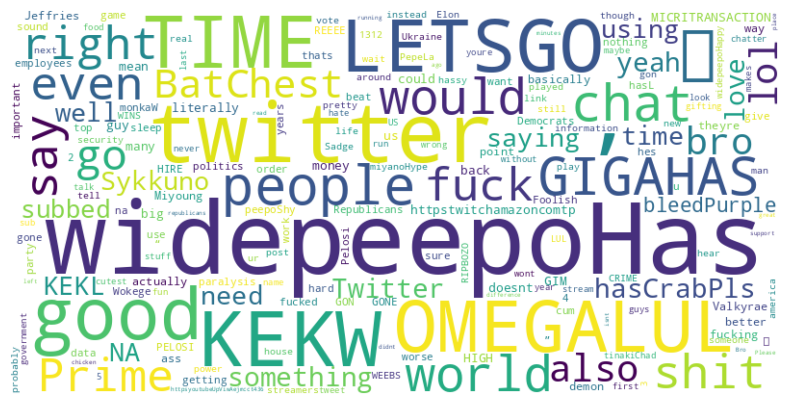

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

print(twitch_df.info())

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['base_prediction'] == 1]['comment_text']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Fine-Tuned Roberta on Twitch Dataset

In [3]:
pip install better-profanity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 978.1 kB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
# global profanity
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    # global profanity
    text_to_predict = row['comment_text']
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    profanity_in = profanity.contains_profanity(text_to_predict)
    # if(count <100):
    #   print(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) < 0.567 and not sub_mention) else 0
    count = count + 1
    if (count % 500 == 0):
      print(count)
    if(count < 50):
      print(np.abs(probabilities[0]))
      print(text_to_predict)
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    # print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('/usr/twitch_toxicity.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['union_prediction'] = twitch_df.apply(predict_label, axis=1)

# Display the DataFrame with predictions
print(twitch_df[['comment_text', 'union_prediction']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['union_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

11449
0.59288466
Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej
0
0.5929191
Nice thats my first time in Hasan Lifestream
0
0.63416034
THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO
0
0.56636995
Dont forget to check ur cocks before stream starts
1
0.62588817
THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO
0
0.5968546
hey guys I'm finally here early, I love you
0
0.5941281
that was crazy timing i ramdomly clicked on him
0
0.5917227
i just clicked without notification bois had a feeling
0
0.57596755
HYPERPOGGER I was here on accident. Catching up on yesterday HYPERPOGGER
0
0.5836104
got here before the notif, yikes I have a problem
0
0.5741286
nakedave587 subscribed with Prime. They've subscribed for 2 months! LFG
0
0.5556311
nakedave587 just subbed using Prime for 2 months! bleedPurple https://twitch.amazon.com/tp
0
0.5978099
@rythympnxa naber agam @HasanAb

# Fine-Tuned Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3     Dont forget to check ur cocks before stream st...
17    @abyssabyss2445 LEFTOVERS PODCAST LATEST EPISO...
25             ur looking good today chat YEP nice cock
28    Hi chat hi mods hasGachi keffalHyper hasGachi ...
31    LETS FUCKING GOOO, I just HAPPENED TO CHECK IF...
Name: comment_text, dtype: object


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

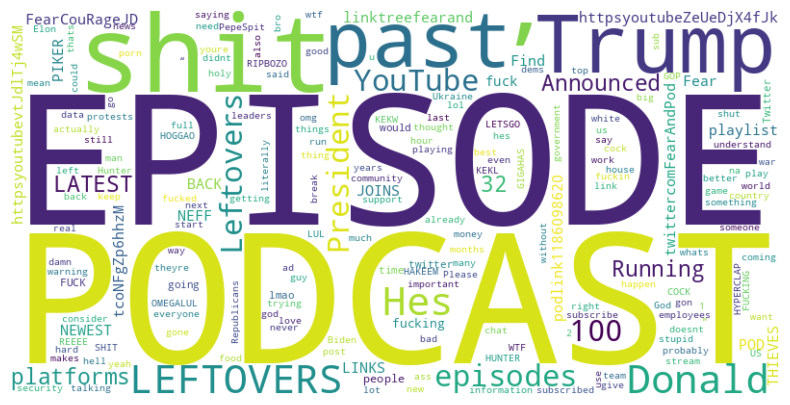

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['union_prediction'] == 1]['comment_text']
print(toxic_comments.head(5))

batch_size = 1000  # Set the batch size
num_rows = len(twitch_df)
with open('union_output.txt', 'w') as f:
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        for index, row in twitch_df.iloc[start:end].iterrows():
            f.write(str(row['union_prediction']) + '\n')

from google.colab import files
files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
